In [9]:
import pandas as pd 
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import warnings
import scipy

import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3


# Set the seed value for experiment reproduci.bility.
seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [2]:
#define image dataset 
#why do we rescale?
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='/local/data1/chash345/train',
                                                 shuffle=True,
                                                 target_size=(299,299), 
                                                 class_mode='binary')

image_generator = ImageDataGenerator(rescale=1/255) 

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='/local/data1/chash345/valid',
                                                 shuffle=False,
                                                 target_size=(299,299),
                                                 class_mode='binary')


test_dataset = image_generator.flow_from_directory(
                                                 directory='/local/data1/chash345/test',
                                                 shuffle=False,
                                                 target_size=(299,299), 
                                                 class_mode=None)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


The dimensions of the image are 299 pixels width and 299 pixels height, one single color channel.
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.3280 and the standard deviation is 0.3159


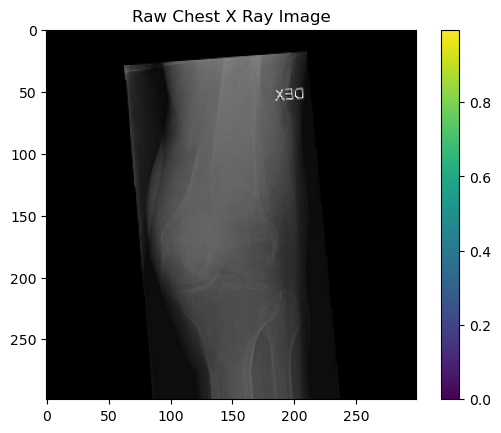

In [3]:
#sns.set_style('white')
generated_image, label = train_dataset.__getitem__(15)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [3]:
inceptionv3 = InceptionV3(input_shape= (299,299,3), include_top=False, weights= 'imagenet' )

2022-12-27 15:17:52.130029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 15:17:52.130356: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [4]:
for layer in inceptionv3.layers:
    layer.trainable = False
#x = Flatten()(model_inception.output)

tf.random.set_seed(150)

model = tf.keras.models.Sequential([
    inceptionv3,
    GlobalAveragePooling2D(),    
    Dense(512,activation="relu"),
    Dropout(0.4),
    Dense(256,activation="relu"),
    Dropout(0.4),
    Dense(128, activation='swish'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [6]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_dataset.classes, classes=np.unique(train_dataset.classes))
dict_weights = {0: weights[0], 1:weights[1]}
dict_weights

{0: 2.5, 1: 0.625}

In [7]:
history = model.fit( train_dataset, 
validation_data= validation_dataset, 
epochs= 50, 
verbose=1, 
class_weight=dict_weights
)

2022-12-07 17:38:20.484739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-07 17:38:20.485131: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz


Epoch 1/10


2022-12-07 17:38:23.715966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-07 17:38:31.330677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-12-07 17:43:51.898799: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-12-07 17:43:51.990475: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


82/82 [==============================] - 862s 6s/step - loss: 1053.3449 - accuracy: 0.6472 - val_loss: 701.7945 - val_accuracy: 0.7966
Epoch 2/10
82/82 [==============================] - 390s 5s/step - loss: 593.4397 - accuracy: 0.7238 - val_loss: 992.3467 - val_accuracy: 0.5563
Epoch 3/10
82/82 [==============================] - 402s 5s/step - loss: 670.9742 - accuracy: 0.7250 - val_loss: 203.5383 - val_accuracy: 0.7989
Epoch 4/10
82/82 [==============================] - 414s 5s/step - loss: 250.8609 - accuracy: 0.7172 - val_loss: 102.1322 - val_accuracy: 0.7989
Epoch 5/10
82/82 [==============================] - 391s 5s/step - loss: 198.8692 - accuracy: 0.7677 - val_loss: 67.8752 - val_accuracy: 0.7989
Epoch 6/10
82/82 [==============================] - 392s 5s/step - loss: 137.5367 - accuracy: 0.7662 - val_loss: 76.9835 - val_accuracy: 0.6977
Epoch 7/10
82/82 [==============================] - 391s 5s/step - loss: 101.3285 - accuracy: 0.7554 - val_loss: 27.9158 - val_accuracy: 0.754

In [ ]:
# save the model weights after training
model = model.save('saved_model')

In [4]:
# Load the saved model anytime for inference
reconstructed_model = keras.models.load_model("saved_model")

2022-12-30 21:19:16.141470: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-30 21:19:16.141736: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [5]:
# Predict classes from this reconstructed model
predcited_classes = reconstructed_model.predict_classes(test_dataset)

2022-12-30 21:19:36.918461: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-30 21:19:36.918823: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz
2022-12-30 21:19:42.695546: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 90935296 exceeds 10% of free system memory.
2022-12-30 21:19:42.787874: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 88510464 exceeds 10% of free system memory.
2022-12-30 21:19:42.881718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 177020928 exceeds 10% of free system memory.
2022-12-30 21:19:43.023966: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43655168 exceeds 10% of free system memory.
2022-12-30 21:19:43.048005: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 54568960 exceeds 10% of free system memory.


In [6]:
# Predict class probabilities from this reconstructed model
predicted_probs = reconstructed_model.predict(test_dataset)

In [7]:
y_true = test_dataset.classes

In [8]:
y_pred = predcited_classes.reshape(1, len(test_dataset.classes))

In [10]:
confusion_matrix(y_true= y_true , y_pred=y_pred[0])

array([[111,  62],
       [186, 505]])

In [16]:
pd.DataFrame(classification_report(y_true, y_pred[0], output_dict=True)).T

,precision,recall,f1-score,support
0,0.373737,0.641618,0.472340,173.000000
1,0.890653,0.730825,0.802862,691.000000
accuracy,0.712963,0.712963,0.712963,0.712963
macro avg,0.632195,0.686222,0.637601,864.000000
weighted avg,0.787150,0.712963,0.736681,864.000000


In [11]:
# %%
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

fpr, tpr, thresholds = roc_curve(test_dataset.classes, predcited_classes)

In [12]:
# %%
roc_auc_score(test_dataset.classes, predicted_probs )


0.7803928293584735

In [13]:
# %%
roc_auc_score(test_dataset.classes, predcited_classes )

0.6862216942857382

In [14]:
roc_auc = auc(fpr, tpr)

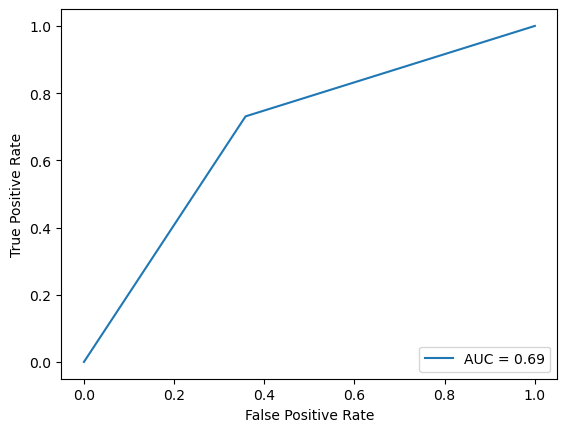

In [15]:
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()
